## Baseline single‑note pitch correction — notebook guide
This notebook trains the lightweight baseline model that predicts per‑frame pitch correction (cents) for sustained notes.

Outline:
1. Imports & config — paths, normalization stats, constants.
2. Load data — build `[T,64]` mel sequences and labels from `.npz`.
3. Model — tiny GRU with heads for `shift_cents` and `confidence`.
4. Train — MAE loss on `shift_cents` vs `target_shift` + early stopping.
5. Export — SavedModel for local checks and TFLite for mobile.

Tip: 100 cents = 1 semitone. Reported MAE is in cents (lower is better).


In [7]:
# Baseline: Single-Note Pitch Correction (Streaming-friendly)

# 1) Imports & Config
import os, json, math, glob, random
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ROOT = Path("/Users/brandontsai/ESE3600/tinymlpitchcorrection")
PROC_DIR = ROOT / "data/processed/features"
META_DIR = ROOT / "metadata"
OUT_DIR = ROOT / "artifacts/baseline"
OUT_DIR.mkdir(parents=True, exist_ok=True)

with open(META_DIR / "feature_norm.json", "r") as f:
    norm = json.load(f)
FEATURE_MEAN = np.array(norm["feature_mean"] or [0.0]*64, dtype=np.float32)
FEATURE_STD = np.array(norm["feature_std"] or [1.0]*64, dtype=np.float32)
FPS = norm.get("frames_per_second", 100)

N_MELS = 64
FRAME_HOP_MS = 10
SHIFT_RANGE_CENTS = 300.0

random.seed(13)
np.random.seed(13)
tf.random.set_seed(13)

print("Config:", dict(n_mels=N_MELS, fps=FPS, shift_range=SHIFT_RANGE_CENTS))


Config: {'n_mels': 64, 'fps': 100, 'shift_range': 300.0}


### Step 2: Load data (single‑note sequences)
This prepares training/validation windows from the processed dataset.
- Load `.npz` files from `data/processed/features/{train,val}`.
- Filter to sustained notes via a simple stability heuristic on `target_shift` over voiced frames.
- Normalize mel frames using `feature_norm.json` mean/std.
- Slice overlapping windows (T=100 frames, stride=50) to build `[batch, T, 64]` inputs and `[batch, T, 1]` labels.


In [8]:
# 2) Data loading: Single-note segments

def list_npz(split):
    return sorted(glob.glob(str(PROC_DIR / split / '*.npz')))

# Heuristic single-note filter: low stddev of target_shift and f0 drift
# This picks stable sustained notes for the baseline

def is_single_note(arr, thr_cents_std=15.0):
    ts = arr['target_shift'].astype(np.float32)
    voiced = arr['voiced'].astype(np.float32) > 0.5
    if voiced.sum() < 20:
        return False
    ts_v = ts[voiced]
    return np.std(ts_v) < thr_cents_std


def normalize_features(x):
    return (x - FEATURE_MEAN[None, :]) / (FEATURE_STD[None, :] + 1e-8)

# Build sequences of length T frames

def make_sequences(npz_paths, T=100, stride=50, limit=None):
    xs, ys = [], []
    count = 0
    for p in npz_paths:
        arr = np.load(p)
        if not is_single_note(arr):
            continue
        logmel = normalize_features(arr['logmel'].astype(np.float32))
        target_shift = arr['target_shift'].astype(np.float32)
        L = len(target_shift)
        i = 0
        while i + T <= L:
            xs.append(logmel[i:i+T])           # [T, 64]
            ys.append(target_shift[i:i+T, None])  # [T, 1]
            i += stride
            count += 1
            if limit and count >= limit:
                break
        if limit and count >= limit:
            break
    return np.array(xs), np.array(ys)

train_files = list_npz('train')
val_files = list_npz('val')
print(f"Found train files={len(train_files)}, val files={len(val_files)}")

X_train, y_train = make_sequences(train_files, T=100, stride=50, limit=None)
X_val, y_val = make_sequences(val_files, T=100, stride=50, limit=None)
print('Shapes:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

BATCH=32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(tf.data.AUTOTUNE)


Found train files=864, val files=108
Shapes: (1350, 100, 64) (1350, 100, 1) (157, 100, 64) (157, 100, 1)


### Step 3: Model (tiny GRU baseline)
A small causal sequence model that maps mel frames → per‑frame pitch correction in cents.
- Input: `[batch, T, 64]` normalized log‑mels.
- Backbone: `GRU(64, return_sequences=True)` with small dense layers.
- Heads: 
  - `shift_cents` (linear) — main regression target (`target_shift`)
  - `confidence` (sigmoid) — optional gating head (baseline uses ones)
Rationale: GRU captures slow pitch trend with near‑zero lookahead and few parameters.


In [9]:
# 3) Model: Tiny GRU (causal-ish) predicting shift_cents and confidence

from tensorflow.keras import layers as L, models

INPUT_DIM = N_MELS
HIDDEN = 64

inputs = L.Input(shape=(None, INPUT_DIM), name='features')
x = L.Dense(64, activation='relu')(inputs)
x = L.GRU(HIDDEN, return_sequences=True, name='gru1')(x)
x = L.Dense(64, activation='relu')(x)
shift = L.Dense(1, activation=None, name='shift_cents')(x)  # linear
conf = L.Dense(1, activation='sigmoid', name='confidence')(x)

model = models.Model(inputs=inputs, outputs=[shift, conf])

# Loss: MAE on shift; small smoothness penalty could be added later
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'shift_cents': 'mae', 'confidence': 'binary_crossentropy'},
    loss_weights={'shift_cents': 1.0, 'confidence': 0.01},
    metrics={'shift_cents': 'mae'}
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, None, 64)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      4,160 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru1 (GRU)          │ (None, None, 64)  │     24,960 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 64)  │      4,160 │ gru1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shift_cents (Dense) │ (None, None, 1)   │         65 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Dense)  │ (None, None, 1)   │         65 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,410 (130.51 KB)

 Trainable params: 33,410 (130.51 KB)

 Non-trainable params: 0 (0.00 B)

### Step 4: Train and validate
We optimize mean absolute error (MAE) on `shift_cents` vs. `target_shift` and a tiny auxiliary BCE on a dummy `confidence` head.
- `train_mapped`: uses `tf.ones_like(y)` as confidence for all voiced frames (baseline simplification).
- Callbacks: ReduceLROnPlateau + EarlyStopping on `val_shift_cents_mae` (lower is better).
- The plot shows train/val MAE in cents (100 cents = 1 semitone).


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - confidence_loss: 0.5606 - loss: 9.8764 - shift_cents_loss: 9.9314 - shift_cents_mae: 9.8707 - val_confidence_loss: 0.3185 - val_loss: 8.3474 - val_shift_cents_loss: 8.3792 - val_shift_cents_mae: 8.3442 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - confidence_loss: 0.2256 - loss: 9.0431 - shift_cents_loss: 9.0360 - shift_cents_mae: 9.0409 - val_confidence_loss: 0.1937 - val_loss: 8.0968 - val_shift_cents_loss: 8.1397 - val_shift_cents_mae: 8.0948 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - confidence_loss: 0.1558 - loss: 8.3507 - shift_cents_loss: 8.2950 - shift_cents_mae: 8.3491 - val_confidence_loss: 0.1335 - val_loss: 8.0202 - val_shift_cents_loss: 8.0560 - val_shift_cents_mae: 8.0189 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - confidence_loss: 0.1070 - loss: 7.9229 - shift_cents_loss: 7.9523 - shift_cents_mae: 7.9218 - val_confidence_l

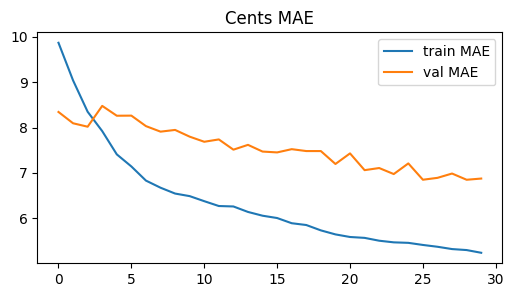

In [10]:
# 4) Training loop

# For validation (numpy arrays), create ones via numpy
def pack_val(y):
    conf = np.ones_like(y, dtype=np.float32)
    return (y, conf)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_shift_cents_mae', mode='min', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_shift_cents_mae', mode='min', patience=7, restore_best_weights=True)
]

# Use tf.ones_like inside the dataset map to avoid NumPy on Tensors
train_mapped = train_ds.map(lambda x, y: (x, (y, tf.ones_like(y))))

history = model.fit(
    train_mapped,
    validation_data=(X_val, pack_val(y_val)),
    epochs=30,
    verbose=1,
    callbacks=callbacks
)

plt.figure(figsize=(6,3))
plt.plot(history.history['shift_cents_mae'], label='train MAE')
plt.plot(history.history['val_shift_cents_mae'], label='val MAE')
plt.legend(); plt.title('Cents MAE'); plt.show()


### Step 5: Export (SavedModel + TFLite)
This section wraps the trained model in a simple serving signature and exports:
- SavedModel (used for local numeric checks and plotting)
- TFLite (mobile deployment; baseline GRU uses Select TF Ops)

Notes:
- The representative dataset is used only for int8 PTQ; in this baseline we keep Select TF Ops for GRU.
- Metadata such as feature dims and hop are stored separately in `metadata/feature_norm.json` and `metadata/tflite_metadata.json`.


In [14]:
# 5) Export to SavedModel and TFLite (int8)

export_dir = OUT_DIR / 'saved_model'
export_dir.mkdir(parents=True, exist_ok=True)

# Wrap for fixed-shape TFLite export
sig_inputs = tf.keras.Input(shape=(None, N_MELS), name='features', dtype=tf.float32)
sig_shift, sig_conf = model(sig_inputs)
serve = tf.keras.Model(inputs=sig_inputs, outputs={'shift_cents': sig_shift, 'confidence': sig_conf})

serve.export(export_dir)
print('SavedModel exported to', export_dir)

# Representative dataset: feature windows

def rep_ds():
    for _ in range(200):
        idx = np.random.randint(0, len(X_train))
        x = X_train[idx:idx+1].astype(np.float32)
        yield [x]

converter = tf.lite.TFLiteConverter.from_saved_model(str(export_dir))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Keep float model and allow Select TF Ops to support GRU export
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

(OUT_DIR / 'tflite').mkdir(exist_ok=True, parents=True)
with open(OUT_DIR / 'tflite' / 'baseline_single_note.tflite', 'wb') as f:
    f.write(tflite_model)
print('TFLite model written.')

tflite_output_name = OUT_DIR / 'tflite' / 'baseline_single_note.tflite'
cc_output_name = OUT_DIR / 'cc' / 'baseline_single_note.cc'
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {tflite_output_name} > {cc_output_name}
# Update variable names
REPLACE_TEXT = str(tflite_output_name).replace('/', '_').replace('.', '_')
!sed -i '' "s/{REPLACE_TEXT}/g_pitch_match_model_data/g" {cc_output_name}


INFO:tensorflow:Assets written to: /Users/brandontsai/ESE3600/tinymlpitchcorrection/artifacts/baseline/saved_model/assets


INFO:tensorflow:Assets written to: /Users/brandontsai/ESE3600/tinymlpitchcorrection/artifacts/baseline/saved_model/assets


Saved artifact at '/Users/brandontsai/ESE3600/tinymlpitchcorrection/artifacts/baseline/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 64), dtype=tf.float32, name='features')
Output Type:
  Dict[['shift_cents', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)], ['confidence', TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)]]
Captures:
  12930701008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12930700048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13270259984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12930699664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12930700816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13270265552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13270258448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13270264976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13270264784: TensorSp

W0000 00:00:1764793248.285913 4050939 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764793248.285927 4050939 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-03 15:20:48.286142: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /Users/brandontsai/ESE3600/tinymlpitchcorrection/artifacts/baseline/saved_model
2025-12-03 15:20:48.286786: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-03 15:20:48.286792: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /Users/brandontsai/ESE3600/tinymlpitchcorrection/artifacts/baseline/saved_model
2025-12-03 15:20:48.292953: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-03 15:20:48.319243: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /Users/brandontsai/ESE3600/tinymlpitchcorrection/artifacts/baseline/saved_model
2025-12-0